## Setup

In [1]:
import reproducibility

In [2]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
import logging

# Configuring the number of threads
#NUM_THREADS = 5
#tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
#tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
# from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2
%matplotlib inline

In [3]:
from utils import logging_setup
logging_setup()

In [4]:
# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan, load_and_fix_data
from data_funcs import raws_data, synthetic_data, plot_data, check_data, rmse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import run_case, run_rnn, create_RNN_2, staircase, train_rnn, rnn_predict

## User options

In [5]:
# Change directory for data read/write

dict_file='data/testing_dict.pickle' # input path of FMDA dictionaries
output_path='outputs/outputs.json' # RNN output file
reproducibility_file='data/reproducibility_dict.pickle'

In [6]:
from module_param_sets import param_sets

In [7]:
param_sets_keys=['0']

In [8]:
# read test datasets
test_dict=load_and_fix_data(dict_file)
logging.info("testing datasets test_dict.keys():%s",test_dict.keys())

repro_dict=load_and_fix_data(reproducibility_file)
logging.info("reproducibity dataset repro_dict.keys(): %s",repro_dict.keys())

After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
2024-04-17 09:33:45,908 - INFO - testing datasets test_dict.keys():dict_keys(['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'])
2024-04-17 09:33:45,910 - INFO - reproducibity dataset repro_dict.keys(): dict_keys(['case11'])


2024-04-17 09:33:45,924 - INFO - params_sets_keys=['0']
i= 0
cases= ['case11']
case= case11 RNN Orig

*****  case11  *****

{'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': 0, 'verbose_weights': False, 'note': 'check 5 should give zero error', 'initialize': True}
case11 Training 1 to 300 hours RMSE:   0.3305
case11 Prediction 301 to 854 hours RMSE: 1.0984
2024-04-17 09:33:46,027 - INFO - run_rnn start
resetting random seeds to 123
2024-04-17 09:33:46,028 - INFO - create_rnn_data_1 start
2024-04-17 09:33:46,029 - INFO - create_rnn_data_1: hours=None h2=None
2024-04-17 09:33:46,030 - INFO - feature matrix X shape (854, 2)
2024-04-17 09:33:46,030 - INFO - target 

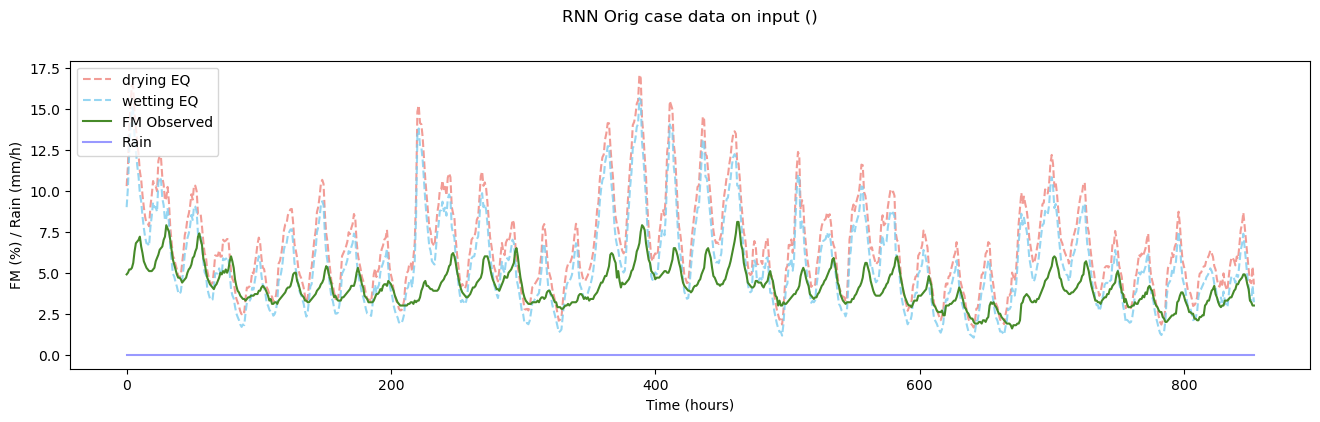

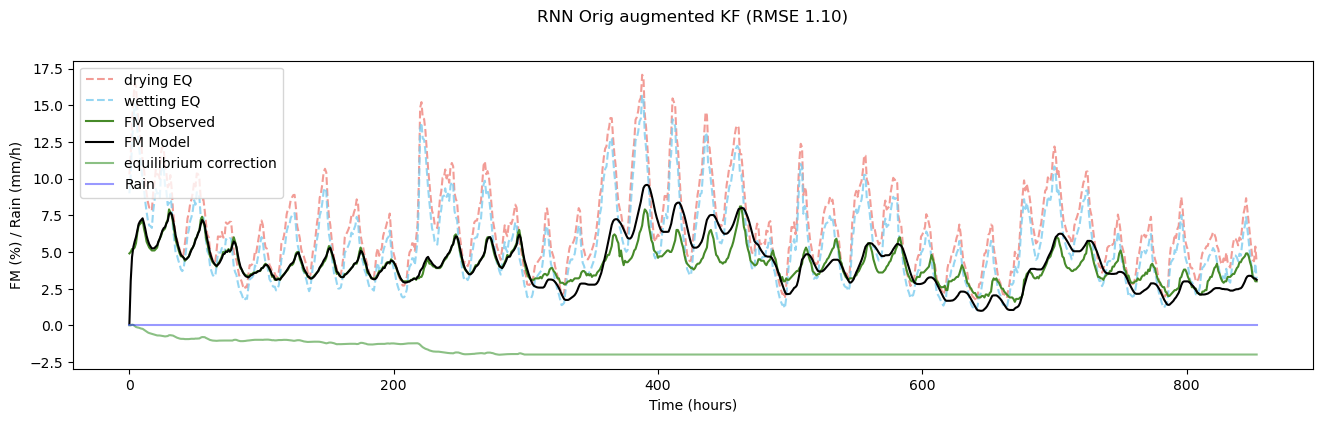

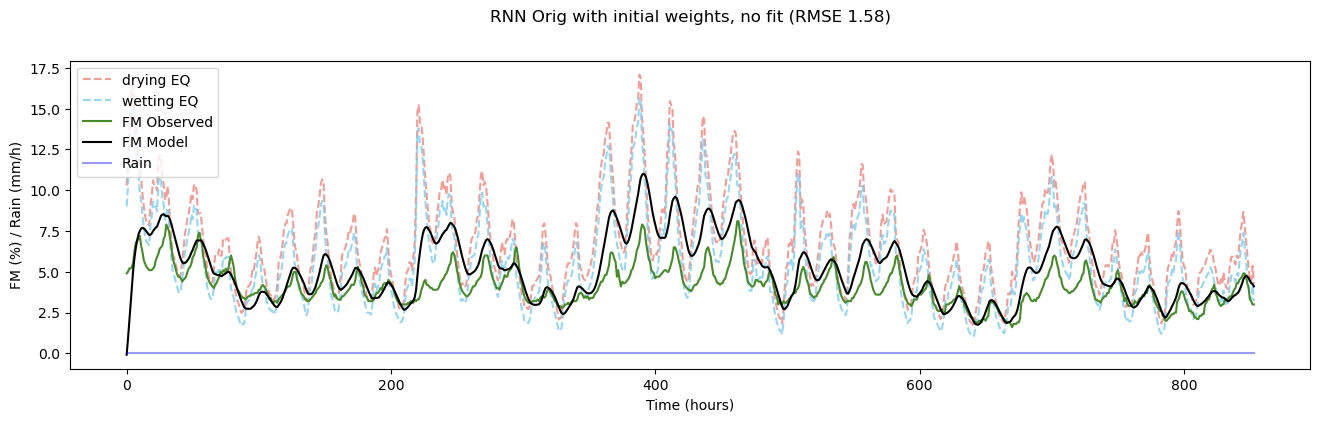

2024-04-17 09:33:47,401 - INFO - run_rnn end
case11 Training 1 to 300 hours RMSE:   1.327
case11 Prediction 301 to 854 hours RMSE: 1.5834
2024-04-17 09:33:47,402 - INFO - run_rnn start
resetting random seeds to 123
2024-04-17 09:33:47,406 - INFO - create_rnn_data_1 start
2024-04-17 09:33:47,407 - INFO - create_rnn_data_1: hours=None h2=None
2024-04-17 09:33:47,407 - INFO - feature matrix X shape (854, 2)
2024-04-17 09:33:47,408 - INFO - target  matrix Y shape (854, 1)
2024-04-17 09:33:47,409 - INFO - features_list: ['Ed', 'Ew']
2024-04-17 09:33:47,410 - INFO - create_rnn_data_2 start
2024-04-17 09:33:47,410 - INFO - batch_size=inf
staircase: shape x =  (854, 2)
staircase: shape y =  (854, 1)
staircase: timesteps= 5
staircase: datapoints= 300
staircase: return_sequences= False
staircase: samples= 296 timesteps= 5 features= 2
returning only the last timestep in a sample
2024-04-17 09:33:47,419 - INFO - x_train shape=(296, 5, 2)
2024-04-17 09:33:47,420 - INFO - y_train shape=(296, 1)
2024

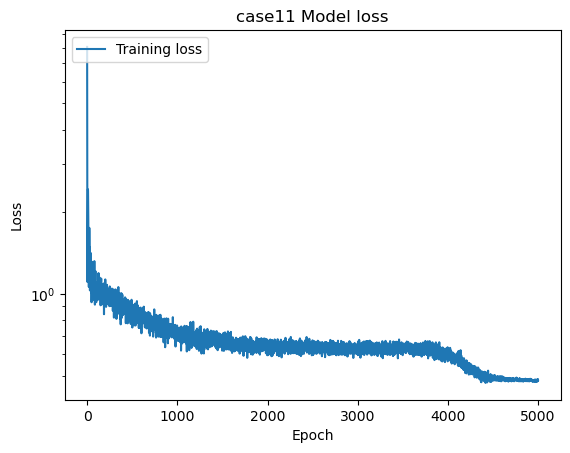

fitted weights hash = 5.55077327554663e+19
1/1 [==============================] - 0s 241ms/step
x_input.shape= (1, 854, 2) y_output.shape= (1, 854, 1)
check 5: 5.55077327554663e+19 should be 5.55077327554663e+19 error 0.0
checkm= 3.77920889854431152  error 0.0
params: {'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': 0, 'verbose_weights': False, 'note': 'check 5 should give zero error', 'initialize': True}


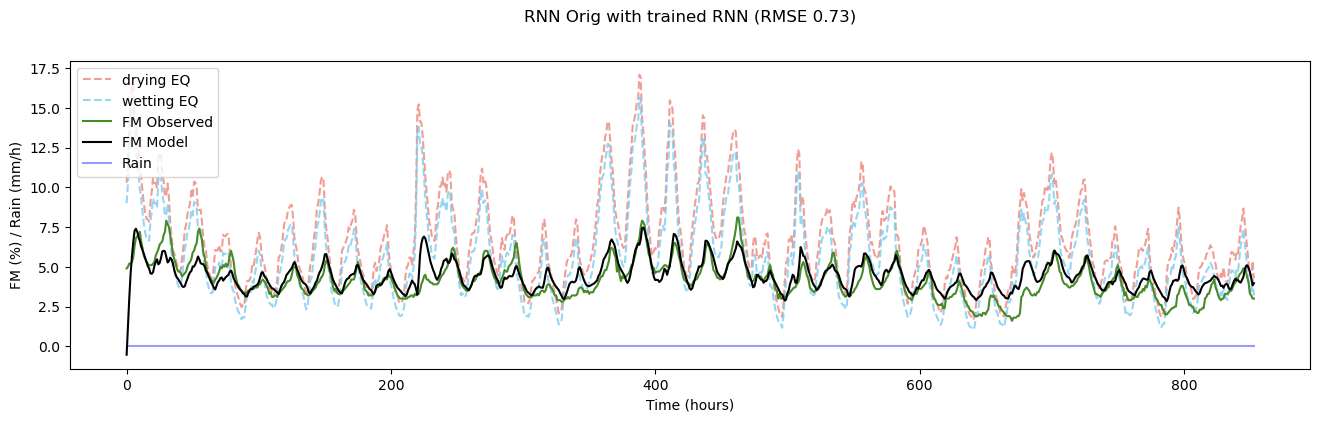

2024-04-17 09:34:02,691 - INFO - run_rnn end
case11 Training 1 to 300 hours RMSE:   0.7998
case11 Prediction 301 to 854 hours RMSE: 0.733
*** params 0 case case11 summary ***
params= {'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': 0, 'verbose_weights': False, 'note': 'check 5 should give zero error', 'initialize': True}
outputs= {
    "initialize": {
        "true": {
            "Augmented KF": {
                "all": 0.9061249439407393,
                "predict": 1.0984268618847821,
                "train": 0.33047073142627476
            },
            "RNN initial": {
                "all": 1.4983486205665615,
                "predict": 1.58343693275214,

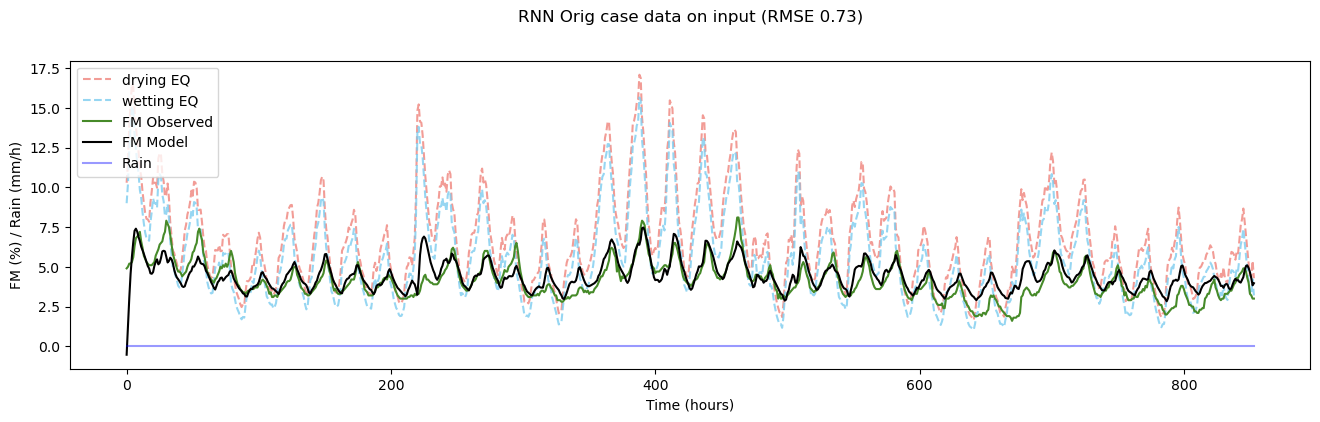

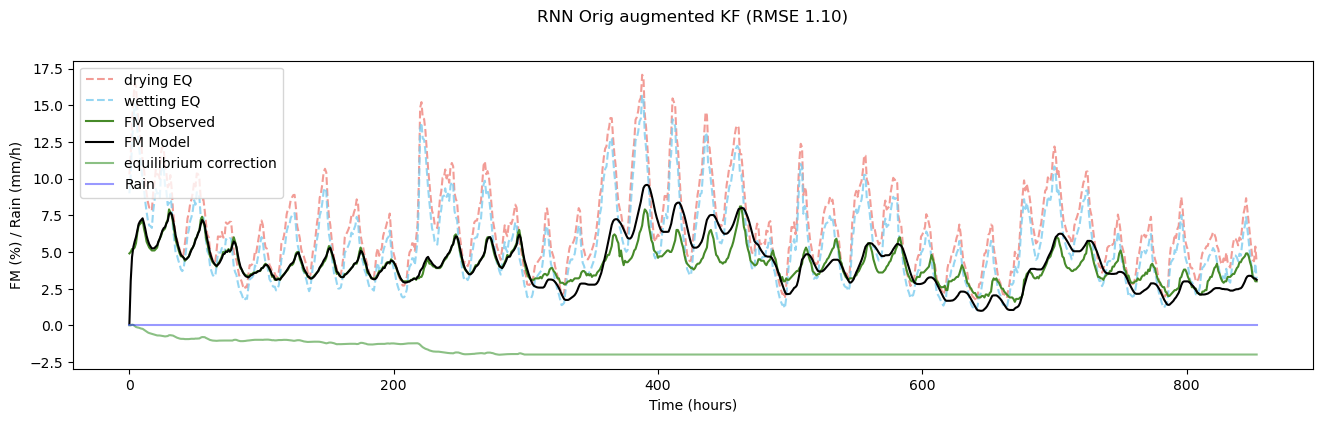

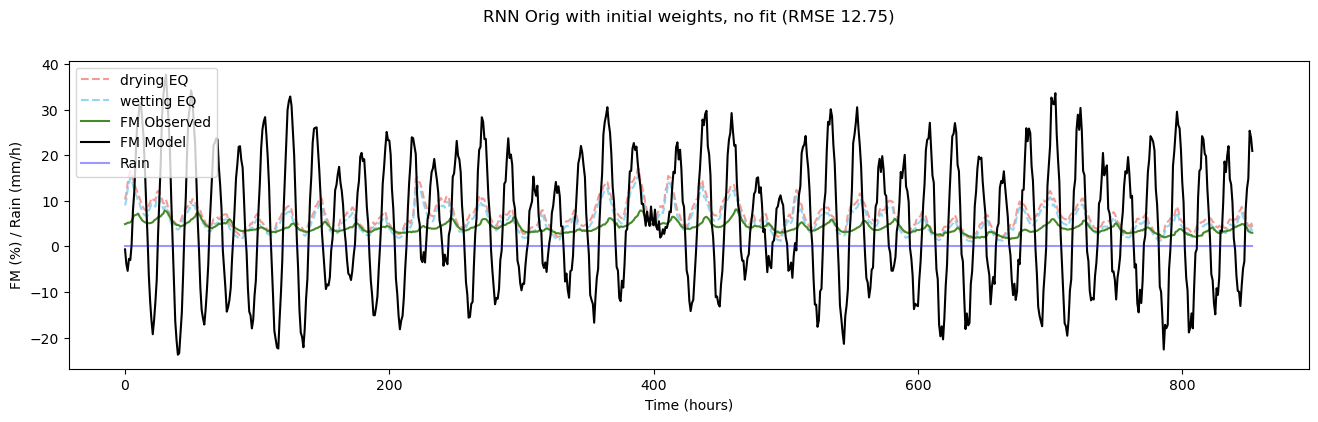

2024-04-17 09:34:03,987 - INFO - run_rnn end
case11 Training 1 to 300 hours RMSE:   14.5875
case11 Prediction 301 to 854 hours RMSE: 12.7463
2024-04-17 09:34:03,988 - INFO - run_rnn start
resetting random seeds to 123
2024-04-17 09:34:03,992 - INFO - create_rnn_data_1 start
2024-04-17 09:34:03,993 - INFO - create_rnn_data_1: hours=None h2=None
2024-04-17 09:34:03,994 - INFO - feature matrix X shape (854, 2)
2024-04-17 09:34:03,994 - INFO - target  matrix Y shape (854, 1)
2024-04-17 09:34:03,995 - INFO - features_list: ['Ed', 'Ew']
2024-04-17 09:34:03,996 - INFO - create_rnn_data_2 start
2024-04-17 09:34:03,996 - INFO - batch_size=inf
staircase: shape x =  (854, 2)
staircase: shape y =  (854, 1)
staircase: timesteps= 5
staircase: datapoints= 300
staircase: return_sequences= False
staircase: samples= 296 timesteps= 5 features= 2
returning only the last timestep in a sample
2024-04-17 09:34:04,003 - INFO - x_train shape=(296, 5, 2)
2024-04-17 09:34:04,004 - INFO - y_train shape=(296, 1)
2

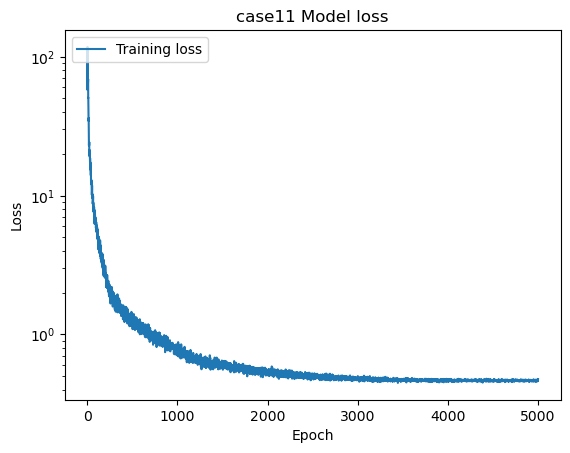

fitted weights hash = 3.5246083873473495e+19
1/1 [==============================] - 0s 250ms/step
x_input.shape= (1, 854, 2) y_output.shape= (1, 854, 1)
check 5: 3.5246083873473495e+19 should be 3.5246083873473495e+19 error 0.0
checkm= 3.77248024940490723  error 0.0
params: {'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': 0, 'verbose_weights': False, 'note': 'check 5 should give zero error', 'initialize': False}


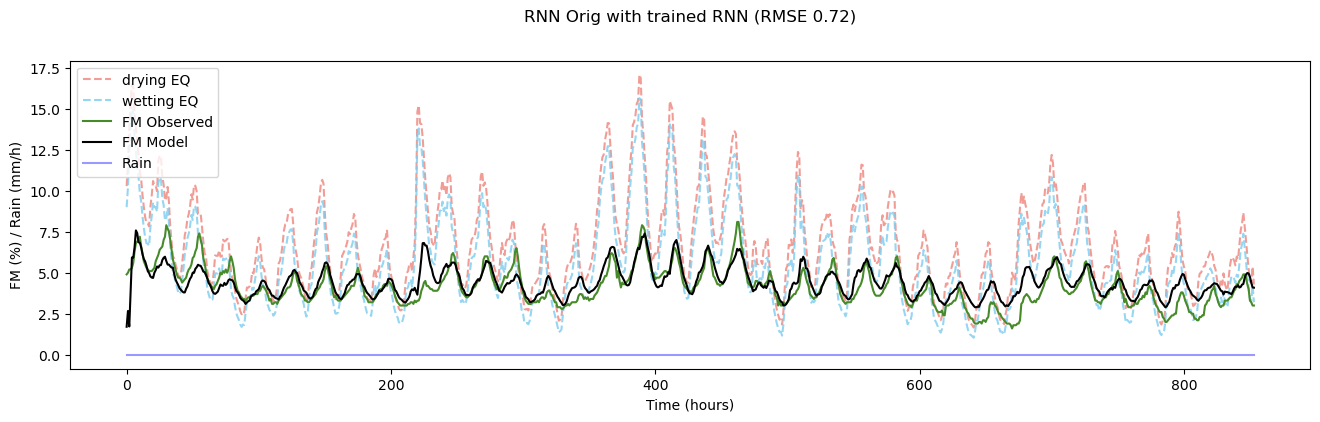

2024-04-17 09:34:20,005 - INFO - run_rnn end
case11 Training 1 to 300 hours RMSE:   0.749
case11 Prediction 301 to 854 hours RMSE: 0.7233
*** params 0 case case11 summary ***
params= {'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': 0, 'verbose_weights': False, 'note': 'check 5 should give zero error', 'initialize': False}
outputs= {
    "initialize": {
        "false": {
            "Augmented KF": {
                "all": 0.9061249439407393,
                "predict": 1.0984268618847821,
                "train": 0.33047073142627476
            },
            "RNN initial": {
                "all": 13.421905873890525,
                "predict": 12.746301348229

In [9]:
output={}
logging.info('params_sets_keys=%s',param_sets_keys)

for i in param_sets_keys:
    print('i=',i)
    params=param_sets[i]
    if i == 0:
        # Run reproducbility case
        print('Running reproducibility')
        assert param_sets[i]['purpose'] == 'reproducibility'
        output[i]={'params':params,'cases':{}}
        case = 'case11'
        case_data=repro_dict[case]
        output[i]['cases'][case]=run_case(case_data,params)
        print('*** params',i,'reproducibility case','summary ***')
        print('params=',params)
        print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
        print('writing the results to file',output_path)
        json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
    else:
        #print('params=',params)
        if params['cases'] == 'all':
            params['cases'] = list(test_dict.keys())
            print("expanding 'all' to",params['cases'])
        output[i]={'params':params,'cases':{}}
        cases = params['cases']
        print('cases=',cases)
        for case in cases:
          for initialize in [True,False]:
            # print(json.dumps(params,indent=4,sort_keys=True))
            case_data=test_dict[case]
            print('case=',case,case_data['title'])
            if not 'title' in case_data.keys():
                case_data['title']=case
            if not 'hours' in case_data.keys():
                case_data['hours']=len(case_data['fm'])
                # case_data['h2']=int(20*24) # length of training period
            if params['synthetic'] or 'Synth' not in case_data['title']: 
                params['initialize']=initialize 
                output[i]['cases'][case]={'initialize':{initialize:run_case(case_data,params)}}  # add to results
                print('*** params',i,'case',case,'summary ***')
                print('params=',params)
                print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
                print('writing the results to file',output_path)
                json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
            else:
                print('skipping synthetic case',case,case_data['title'])
        print('cases=',cases)
print(json.dumps(output,indent=4,sort_keys=True))
   

In [10]:
logging.info('fmda_rnn_rain.ipynb done')

2024-04-17 09:34:20,014 - INFO - fmda_rnn_rain.ipynb done
